In [1]:
import math
import yaml
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.stats import kstest
from tools_util import readModelInputs, getFacDict
from pyrheautils import pathTranslate

In [4]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_OC.yaml'

inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)


In [5]:
# this happens to be UCIM
icuLM = {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.6420696490323798, 0.7]}
icuCRV = lognorm(icuLM['parms'][1], scale=math.exp(icuLM['parms'][0]))


In [7]:
with open(pathTranslate('$(MODELDIR)/constants/hospital_constants.yaml'), 'rU') as f:
    hospConstants = yaml.load(f)
wardSz = hospConstants['bedsPerICUWard']['value']
print wardSz

12


[-0.05129329 -0.05129329 -0.05129329 -0.05129329 -0.05129329 -0.05129329
 -0.05129329 -0.05129329 -0.05129329 -0.05129329 -0.05129329 -0.05129329]


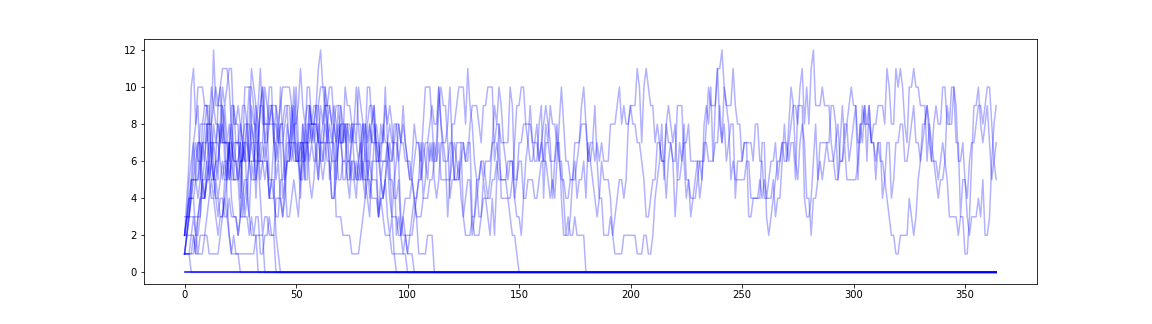

In [48]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [16, 4.5]

initialPrev = 0.1
tau = 0.04
runDays = 365
instances = 20
logOneMinusTau = np.log(1.0 - tau)
print logOneMinusTauV
xV = np.linspace(0, runDays-1, runDays)
for instance in xrange(instances):
    patientV = np.random.choice(2, wardSz, p=[1.0 - initialPrev, initialPrev])
    #print patientV
    endDateV = np.round(icuCRV.rvs(wardSz))
    #print endDateV
    countV = np.zeros([runDays])
    for day in xrange(runDays):
        nColonized = np.sum(patientV)
        countV[day] = nColonized
        newEnd = np.round(icuCRV.rvs(wardSz)) + day
        logPSafe = 0.0 + nColonized * logOneMinusTau
        pExposed = 1.0 - np.exp(logPSafe)
        choices = np.random.choice(2, wardSz, p=[1.0 - pExposed, pExposed])
        patientV = np.choose(choices, [patientV, np.ones(wardSz, dtype=np.int)])
        patientV = np.choose(endDateV >= day, [0, patientV])
        endDateV = np.choose(endDateV >= day, [newEnd, endDateV])
    plt.plot(xV, countV, 'b-', alpha=0.3)
plt.show()